# Libraries

In [1]:
import numpy as np
from keras.datasets import mnist
from torch.utils.data import Dataset
from typing import Optional
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torch import nn
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision
from matplotlib import pyplot as plt
import torchvision.transforms as T

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\setuptools\distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


# Data

Загрузим данные и посмотрим на их количество
- В файле **Mnist_X.npy** изображения, в **Mnist_y.npy** - ответы;
- Для тренировки используем первые **60000** экземпляров, для теста -- **10000**.

In [2]:
X = np.load('../SimpleNet/Mnist_X.npy')
y = np.load('../SimpleNet/Mnist_y.npy')
print(X.shape)
print(y.shape)

(70000, 28, 28)
(70000,)


In [3]:
train_X, test_X = X[:60000], X[60000:]
train_y, test_y = y[:60000], y[60000:]
print('X_train: ' + str(train_X.shape))
print('Y_train: ' + str(train_y.shape))
print('X_test:  '  + str(test_X.shape))
print('Y_test:  '  + str(test_y.shape))

X_train: (60000, 28, 28)
Y_train: (60000,)
X_test:  (10000, 28, 28)
Y_test:  (10000,)


## Dataset

Создадим класс с данными, который будет реалзовывать все необходимые для обучения сети методы:
- Начальная инициализация:
    - Задаем режим, для которого эти данные выбираются: **тренировка train**, **валидация val**, **тестирование test**;
    - Равномерное деление на валидацию и тестирование: создадим словарь, в котором будем хранить кол-во представителей каждого класса. Когда добавляем элемент, увеличиваем соответствующий счетчик;
    - Задаем параметр деления выборки(в каком соотношении на тренировочную и валидационную). 
- Вернуть длину выборки датасета
- Получить элемент из выбоки:
    - Изображение (28 на 28 пикселей) представить в виде одного вектора длины 784
    - Представить вектор в тип данных для torch и вернуть пару (вектор и метка класса).

In [4]:
# Dataset class
class MyCustomDataset(Dataset):
    def __init__(self, 
                 mode,
                 X,
                 y,
                 fraction: float = 0.8,
                ):
        ## list of tuples: (img, label)
        self._items = []
        train_len = fraction*X.shape[0]
        class_cnt = {i: 0 for i in range(10)}
        class_len = train_len//10
        
        np.random.seed(42)
        if mode == 'train' or mode == 'val':
            for i in range(X.shape[0]):
                if len(self._items) < train_len and class_cnt[y[i]] < class_len:
                    if mode == 'train':
                        self._items.append((X[i], y[i]))
                    class_cnt[y[i]] += 1
                else:
                    if mode == 'val':
                        self._items.append((X[i], y[i]))
                    
        else:
            self._items = list(zip(X, y))
        np.random.shuffle(self._items)

    def __len__(self):
        return len(self._items)

    def __getitem__(self, index):
        img, label = self._items[index]

        img = np.stack([img], axis=2)
        img = torch.from_numpy(img)

        return img, label

In [5]:
ds_train = MyCustomDataset('train', train_X, train_y)

In [6]:
ds_val = MyCustomDataset('val', train_X, train_y)

In [7]:
ds_test = MyCustomDataset('test', test_X, test_y)

In [8]:
len(ds_train), len(ds_val), len(ds_test)

(48000, 12000, 10000)

## Пример

Покажем, как из данных датасета получить изображение и его метку

Цифра 9


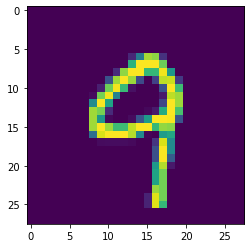

In [9]:
im, label = ds_train[0]
im = im.detach().cpu().numpy()
plt.imshow(im)
print(f'Цифра {label}')

## Упаковываем данные в батчи, которые будут поступать на вход сети

In [10]:
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True, num_workers=0)
dl_val = DataLoader(ds_val, batch_size=32, shuffle=False, num_workers=0)
dl_test = DataLoader(ds_test, batch_size=32, shuffle=False, num_workers=0)

# Model


In [11]:
class MyModel(pl.LightningModule):
    # REQUIRED
    def __init__(self, input_shape=(3, 130, 130), test_data=dl_test, num_classes=10, freeze=True):
        super().__init__()
        """ Define computations here. """
        
        # Описываем модель
        # Два сверточных блока
        self.conv1 = nn.Conv2d(1, 16, 5, padding=2)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2)
        self.norm1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, 5, padding=2)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2)
        self.norm2 = nn.BatchNorm2d(32)

        # Полносвязный слой
        self.fc1 = nn.Linear(32*7*7, 100)
        self.act3 = nn.LeakyReLU(0.1)
        self.drop1 = nn.Dropout(0.1)
        self.fc2 = nn.Linear(100, 10)
        
        # Для оценки качества на тестовых данных можем указать 
        # сразу данные, на которых и будет производиться эта оценка
        self.test_data = test_data
        
        # В качестве ошибки выступает кросс-энтропия
        self.loss = F.cross_entropy
        
        # Дополнительно посмотрим на метрику точности, т.к. она более понятна
        self.accuracy = lambda x, y: (x.argmax(-1) == y).float().mean()
    
    # REQUIRED
    def forward(self, x):
        """ Use for inference only (separate from training_step). """
        # Чтобы избежать ошибок, переводим данные в нужный формат
        x = x.type(torch.FloatTensor)
        x = x.permute(0, 3, 1, 2)
        
        # Описываем поведение сети, т.е. как она проходит 
        # через 1-ый слой свертки, 
        x = self.norm1(self.pool1(self.act1(self.conv1(x))))
        # 2-ой слой свертки
        x = self.norm2(self.pool2(self.act2(self.conv2(x))))
        # переход к полносвязным слоям
        x = x.view(x.size(0), -1)
        x = self.drop1(self.act3(self.fc1(x)))
        x = self.fc2(x)
    
        return x
    
    # REQUIRED -- в конце каждого этапа обучения будут сохраняться результаты 
    # ошибок и точности на данной эпохе для обуающей выборки
    def training_step(self, batch, batch_idx):
        """the full training loop"""
        x, y = batch
        
        x = x.type(torch.FloatTensor)
        y = y.type(torch.LongTensor)

        y_logit = self(x)
        loss = self.loss(y_logit, y)
        
        acc = self.accuracy(y_logit, y)

        return {'loss': loss, 'acc': acc}

    # REQUIRED -- определяем оптимизатор и задаем learning rate
    # P.s. еще можно указать как менять скорость обучения, 
    #      но тут мало эпох и слишком простая задача для этого
    def configure_optimizers(self):
        """ Define optimizers and LR schedulers. """
        optimizer = torch.optim.Adam(self.parameters(), lr=0.01)
        
        return optimizer
    
    # OPTIONAL -- как и с обучающими, но тут результаты на валидации, чтобы отслеживать переобучение
    def validation_step(self, batch, batch_idx):
        """the full validation loop"""
        x, y = batch

        x = x.type(torch.FloatTensor)
        y = y.type(torch.LongTensor)
            
        y_logit = self(x)
        loss = self.loss(y_logit, y)
        
        acc = self.accuracy(y_logit, y)

        return {'val_loss': loss, 'val_acc': acc}

    # OPTIONAL -- как раз визуализация среднего значения результатов на обучающей выборке
    def training_epoch_end(self, outputs):
        """log and display average train loss and accuracy across epoch"""
        avg_loss = torch.stack([x['loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['acc'] for x in outputs]).mean()
        
        print(f"| Train_acc: {avg_acc:.2f}, Train_loss: {avg_loss:.2f}" )
        
        self.log('train_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('train_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)
     
    # OPTIONAL -- то же самое для валидации
    def validation_epoch_end(self, outputs):
        """log and display average val loss and accuracy"""
        avg_loss = torch.stack([x['val_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['val_acc'] for x in outputs]).mean()
        
        print(f"[Epoch {self.trainer.current_epoch:3}] Val_loss: {avg_loss:.5f} Val_accuracy: {avg_acc:.5f}", end= " ")
        
        self.log('val_loss', avg_loss, prog_bar=True, on_epoch=True, on_step=False)
        self.log('val_acc', avg_acc, prog_bar=True, on_epoch=True, on_step=False)
    
    # Оценка качества на тестовой выборке
    def test_step(self, batch, batch_idx):
        x, y = batch
        
        x = x.type(torch.FloatTensor)
        y = y.type(torch.LongTensor)
        
        logits = self(x)
        loss = self.loss(logits, y)
        acc = self.accuracy(logits, y)

        # Calling self.log will surface up scalars for you in TensorBoard
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", acc, prog_bar=True)
        
    # Какие данные сеть полагает тестовыми
    def test_dataloader(self):
        return self.test_data

# Обучение

1. Создаем модель
2. Задаем "учителя"
3. Запускаем процесс обучения

In [12]:
m = MyModel()
print(m)

MyModel(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act1): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (act2): ReLU()
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (norm2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=1568, out_features=100, bias=True)
  (act3): LeakyReLU(negative_slope=0.1)
  (drop1): Dropout(p=0.1, inplace=False)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)


In [13]:
trainer = pl.Trainer(
    max_epochs=2,
    gpus=0,
)

GPU available: False, used: False
TPU available: None, using: 0 TPU cores


In [14]:
trainer.fit(m, dl_train, dl_val)


   | Name  | Type        | Params
---------------------------------------
0  | conv1 | Conv2d      | 416   
1  | act1  | ReLU        | 0     
2  | pool1 | MaxPool2d   | 0     
3  | norm1 | BatchNorm2d | 32    
4  | conv2 | Conv2d      | 12.8 K
5  | act2  | ReLU        | 0     
6  | pool2 | MaxPool2d   | 0     
7  | norm2 | BatchNorm2d | 64    
8  | fc1   | Linear      | 156 K 
9  | act3  | LeakyReLU   | 0     
10 | drop1 | Dropout     | 0     
11 | fc2   | Linear      | 1.0 K 
---------------------------------------
171 K     Trainable params
0         Non-trainable params
171 K     Total params
0.685     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 5.86109 Val_accuracy: 0.09375 

c:\users\user\appdata\local\programs\python\python39\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: 0it [00:00, ?it/s]

| Train_acc: 0.95, Train_loss: 0.16


Validating: 0it [00:00, ?it/s]

[Epoch   0] Val_loss: 0.08065 Val_accuracy: 0.97658 | Train_acc: 0.98, Train_loss: 0.08


Validating: 0it [00:00, ?it/s]

[Epoch   1] Val_loss: 0.06855 Val_accuracy: 0.98225 

1

# Результаты на тестовых данных

In [15]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9821000099182129, 'test_loss': 0.0639115571975708}
--------------------------------------------------------------------------------


[{'test_loss': 0.0639115571975708, 'test_acc': 0.9821000099182129}]